In [38]:
import importlib
import utils
importlib.reload(utils)
from utils import extract_pool,model_grps_config
import utils.optim_utils
importlib.reload(utils.optim_utils)
from utils.optim_utils import optim, optim_pool
from utils.data_utils import load_obj, SAVE_DIR, UD_PARENT, RESULTS_DIR, LEX_PATH_SET, save_obj
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
from tqdm import tqdm
import tsnecuda
import seaborn as sns 
import pandas as pd 
import os 
ANALYZE_DIR='/om/user/ehoseini/MyData/sent_sampling/analysis/'

In [39]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

In [40]:
# load score data 

In [41]:
mode_='50_comp'

In [42]:
model='gpt2-untrained'
group=f'{model}_layers'

#group='roberta-base_layers'
#group='xlnet-large-cased_layers'
#group='bert-large-uncased-whole-word-masking_layers'
#group='xlm-mlm-en-2048_layers'
#group='albert-xxlarge-v2_layers'
#group='ctrl_layers'
dataset='ud_sentencez_token_filter_v3'
activatiion_type='activation'
average='False'
name=f'group={group}-dataset={dataset}-{activatiion_type}-bench=None-ave={average}'
test=extract_pool[name]()
model_layers=test.layer_name
test.load_dataset()
test()

loading /om/user/ehoseini/MyData/Universal Dependencies 2.6/ud_sentencez_data_token_filter_v3_no_dup.pkl


934it [00:00, 189818.78it/s]
934it [00:00, 185539.45it/s]
935it [00:00, 202691.45it/s]
934it [00:00, 204557.46it/s]
934it [00:00, 202547.95it/s]
935it [00:00, 201307.65it/s]
934it [00:00, 206433.05it/s]
934it [00:00, 203770.09it/s]
935it [00:00, 209872.32it/s]


extracting network activations for gpt2-untrained
ud_sentencez_token_filter_v3_gpt2-untrained_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/ud_sentencez_token_filter_v3_gpt2-untrained_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-untrained
ud_sentencez_token_filter_v3_gpt2-untrained_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/ud_sentencez_token_filter_v3_gpt2-untrained_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-untrained
ud_sentencez_token_filter_v3_gpt2-untrained_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/ud_sentencez_token_filter_v3_gpt2-untrained_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-untrained
ud_sentencez_token_filter_v3_gpt2-untr

In [43]:
sentences=[]
sentences=[x['text'] for x in test.data_]


In [44]:
assert(torch.cuda.is_available())

In [45]:
str(np.unique(test.model_spec).squeeze())

'gpt2-untrained'

In [46]:
optim_name='coordinate_ascent_eh-obj=D_s-n_iter=50-n_samples=25-n_init=1-run_gpu=True'
optim_obj=optim_pool[optim_name]()
optim_obj.load_extractor(test)
del test

In [47]:
scores=pd.read_csv(os.path.join(SAVE_DIR,'scoresscoresscores','scores-Pereira2018-encoding-normalized.csv'))


In [48]:
score_layer=list(scores['layer'][scores['model']==model])
score_benchmark=list(scores['benchmark'][scores['model']==model])
score_score=np.asarray(scores['score'][scores['model']==model])
score_error=np.asarray(scores['error'][scores['model']==model])

In [49]:
activation_list = [torch.tensor(x['activations'], dtype=float, device=optim_obj.device, requires_grad=False) for x in
                           optim_obj.activations]
layer_id_list = [int(x['layer']) for x in optim_obj.activations]

# compute PCA

In [50]:
var_explained=[]
loadings=[]
components=[]
for idx, act in tqdm(enumerate(activation_list)):
    # act must be in m sample * n feature shape 
    u,s,v=torch.pca_lowrank(act,q=500)
    loadings.append(torch.matmul(u,torch.diag(s)))
    components.append(v)
    var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
var_explained=torch.stack(var_explained).cpu()

13it [00:14,  1.11s/it]


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


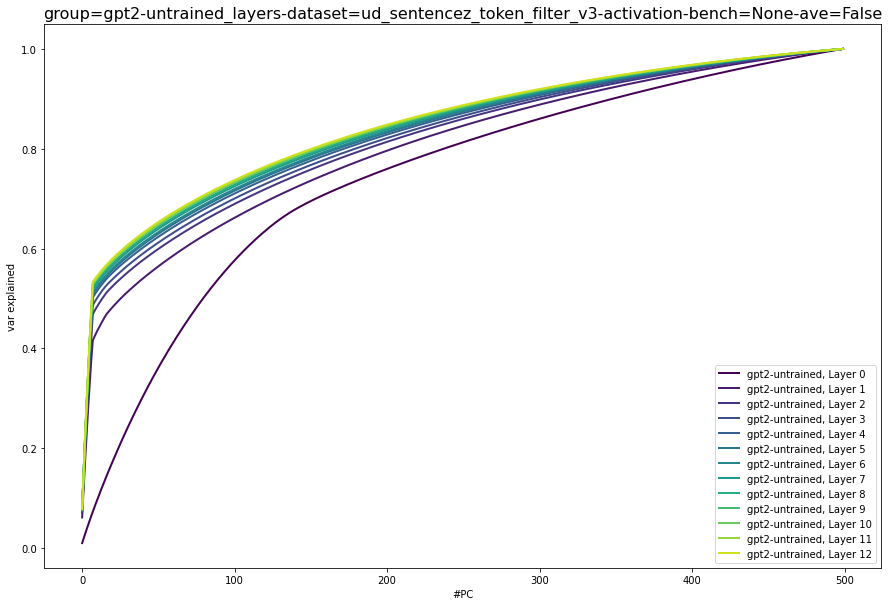

In [51]:
num_colors=len(activation_list)+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

plt.figure(figsize=(15,10))

ax=plt.subplot(1,1,1)
[ax.plot(x,color=line_cols[idx,:],linewidth=2,label=f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}") for idx,x in enumerate(var_explained)]
ax.legend()
ax.set_xlabel('#PC')
ax.set_ylabel('var explained')
ax.set_title(f"{name}",fontsize=16)
plt.savefig(os.path.join(ANALYZE_DIR,f"{name}_layer_var_explained.png"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


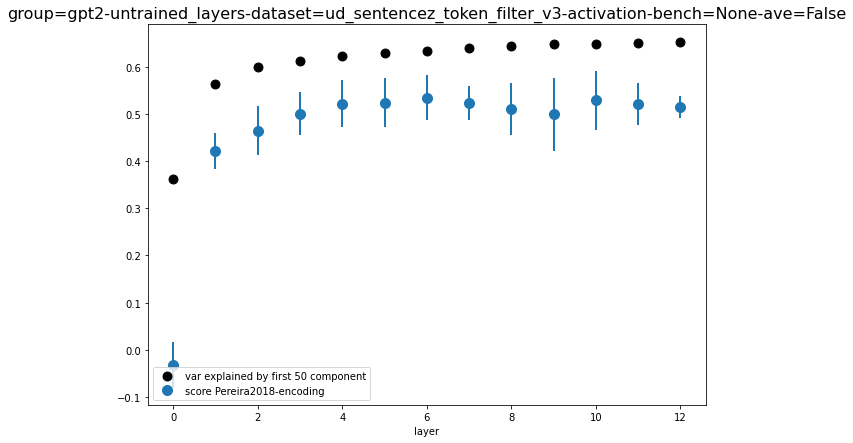

In [52]:
# plot gpt pca var explained vs. score 
plt.figure(figsize=(10,7))
ax=plt.subplot(1,1,1)
ax.errorbar(np.arange(len(layer_id_list)),score_score[layer_id_list],yerr=score_error[layer_id_list],markersize=10,marker='o',linewidth=0,elinewidth=2,label=f'score {score_benchmark[0]}')

ax.scatter(np.arange(len(layer_id_list)),var_explained[:,50],s=80,marker='o',color=(0,0,0),label='var explained by first 50 component')
ax.legend()
ax.set_xlabel('layer')
ax.set_title(f"{name}",fontsize=16)
#ax=plt.subplot(1,2,2)
#ax.plot(score_score[layer_id_list],var_explained[:,50],marker='o',color=(0,0,0))
#ax.set_xlim(-.1,1.1)
#ax.set_ylim(-.1,1.1)
plt.savefig(os.path.join(ANALYZE_DIR,f"{name}_layer_dim_vs_score.png"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


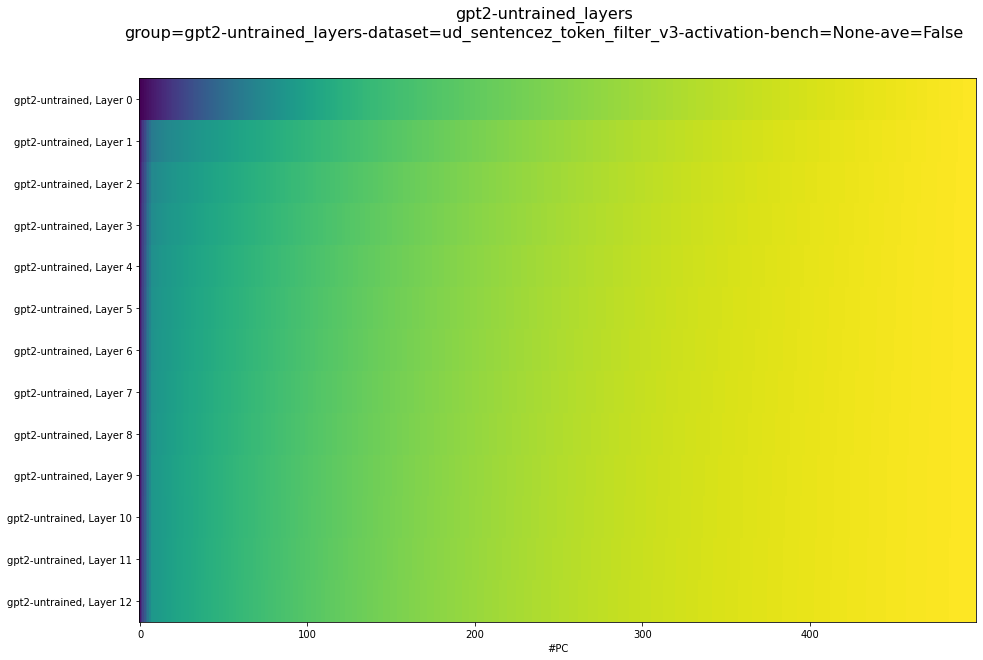

In [53]:
plt.figure(figsize=(15,10))
plt.suptitle(f"{group}\n{name}",fontsize=16)
ax=plt.subplot(1,1,1)
ax.imshow(var_explained,aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}" for idx,x in enumerate(var_explained) ])
ax.set_xlabel('#PC')
plt.savefig(os.path.join(ANALYZE_DIR,f"{name}_PCA_explained_var.png"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

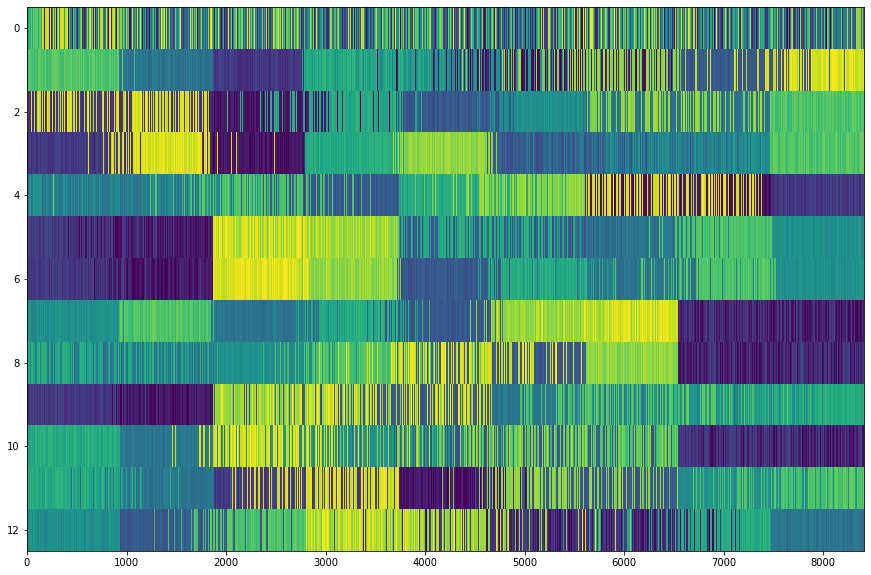

In [54]:
plt.figure(figsize=(15,10))
ax=plt.subplot(1,1,1)
load_sort=torch.stack([torch.argsort(x[:,0]) for x in loadings])
ax.imshow(load_sort.cpu(),aspect='auto',interpolation='none')

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


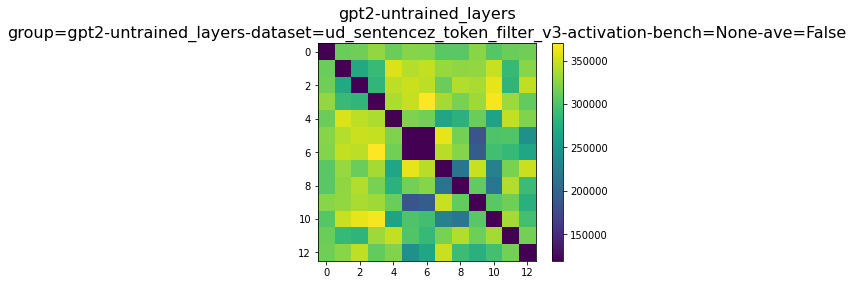

In [55]:
distance=(pdist(load_sort.cpu(),'euclidean'))
plt.imshow(squareform(pdist(load_sort.cpu(),'euclidean')),vmin=np.min(distance),vmax=np.max(distance))
plt.colorbar()
plt.title(f"{group}\n{name}",fontsize=16)

plt.savefig(os.path.join(ANALYZE_DIR,f"{name}_layer_PCA_similarity.png"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

In [56]:
loadings_p12=[x[:,0:2].cpu() for x in loadings]
loadings_p12_norm=[x/torch.norm(x,dim=1,keepdim=True) for x in loadings_p12]
loadings_p12_len=[1e1*torch.norm(x,dim=1,keepdim=True) for x in loadings_p12]

(-0.31209182971288174,
 0.267979216317803,
 -0.2786036517649376,
 0.3479143850842127)

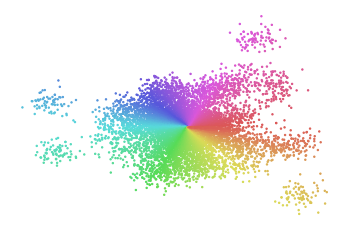

In [57]:
angle=np.arccos(loadings_p12_norm[0][:,0].numpy())
y_cos=loadings_p12_norm[0][:,1].numpy()
angle_fixed=[angle[idy] if y > 0 else np.pi*2-angle[idy] for idy,y in enumerate(y_cos)]
mag_angle=loadings_p12_len[0].squeeze()+1e3*torch.tensor(angle_fixed)
rot=np.argsort(mag_angle)

num_colors=int(rot.shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

fig, ax = plt.subplots()
ax.scatter(loadings_p12[0][rot,0].cpu(),loadings_p12[0][rot,1].cpu(),s=2,c=line_cols)
ax.axis('off')

In [58]:
rot_list=[]
all_angle_fixed=[]
for idx, load_norm in enumerate(loadings_p12_norm):
    angle=np.arccos(load_norm[:,0].numpy())
    y_cos=load_norm[:,1].numpy()
    angle_fixed=[angle[idy] if y > 0 else np.pi*2-angle[idy] for idy,y in enumerate(y_cos)]
    mag_angle=loadings_p12_len[idx].squeeze()+1e3*torch.tensor(angle_fixed)
    all_angle_fixed.append(angle_fixed)
    rot=np.argsort(angle_fixed)
    #rot=np.argsort(mag_angle)
    rot_list.append(rot)


13it [00:15,  1.16s/it]
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


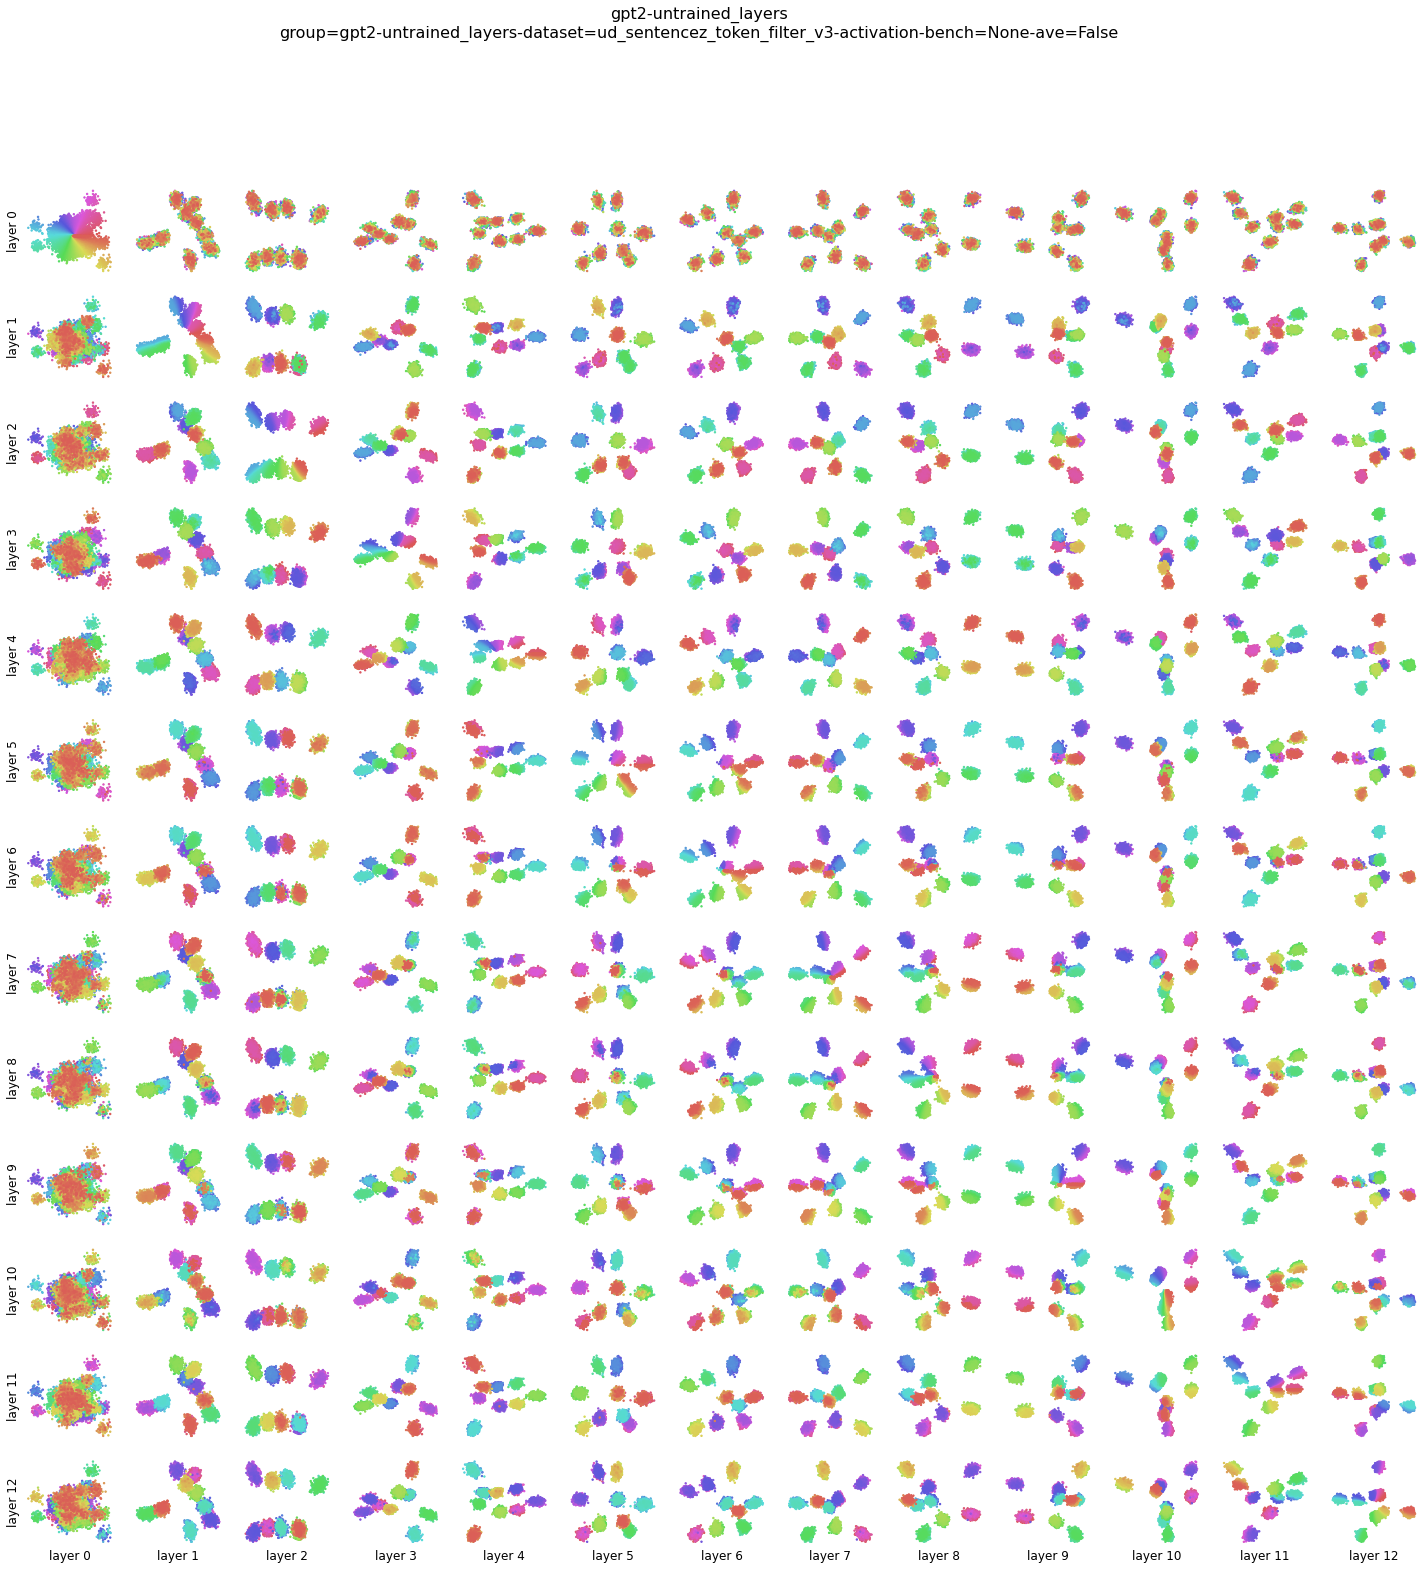

In [59]:
num_layers=len(activation_list)
plt.figure(figsize=(25,25))
num_colors=int(rot_list[0].shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
plt.suptitle(f"{group}\n{name}",fontsize=16)
counter=0                
for idx,_ in tqdm(enumerate(range(len(rot_list)))):
    rot=rot_list[idx]
    
    for idy in range(len(loadings_p12)):
        #print(counter)
        l_v=loadings_p12[idy]
        counter=counter+1
        ax=plt.subplot(num_layers,num_layers,counter)
        ax.scatter(l_v[rot,0].cpu(),l_v[rot,1].cpu(),s=2,c=line_cols)
        #ax.axis('off')
        right_side = ax.spines["right"]
        right_side. set_visible(False)
        right_side = ax.spines["top"]
        right_side. set_visible(False)

        right_side = ax.spines["left"]
        right_side. set_visible(False)
        right_side = ax.spines["bottom"]
        right_side. set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if np.mod(counter,num_layers)==1:
             ax.set_ylabel(f"layer {optim_obj.activations[idx]['layer']}",rotation=90,fontsize=12)
        if counter>num_layers**2-num_layers:
            ax.set_xlabel(f"layer {optim_obj.activations[idy]['layer']}",rotation=0,fontsize=12)
            
plt.savefig(os.path.join(ANALYZE_DIR,f"{name}_layer_PCA_alignments.png"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

In [60]:
!pip install openpyxl

# plot sentences on tSNE space

In [61]:
# first find ev sentences 
file_name='U01_sentselection_Dec18-2020_updDec23.xlsx'
df_ev_selected=pd.read_excel(os.path.join(RESULTS_DIR,f"{file_name}"))

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [62]:
plot_ev_select=True
if plot_ev_select:
    ev_sentences=df_ev_selected.sentence[df_ev_selected.previously_selected_by_ev==1]
    ev_sent_id=([sentences.index(ev_sent) for ev_sent in ev_sentences])


In [63]:
pereira_settings=extract_pool['group=best_performing_pereira_1-dataset=ud_sentences-activation-bench=None-ave=False']()


try :
    model_loc = pereira_settings.model_spec.index(model)
    pereira_layer_id=pereira_settings.layer_spec[model_loc]
except ValueError as e:
    pereira_layer_id=np.argmax(score_score)

In [64]:
ax_lims=np.quantile(l_v,(.005,.995),axis=0)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


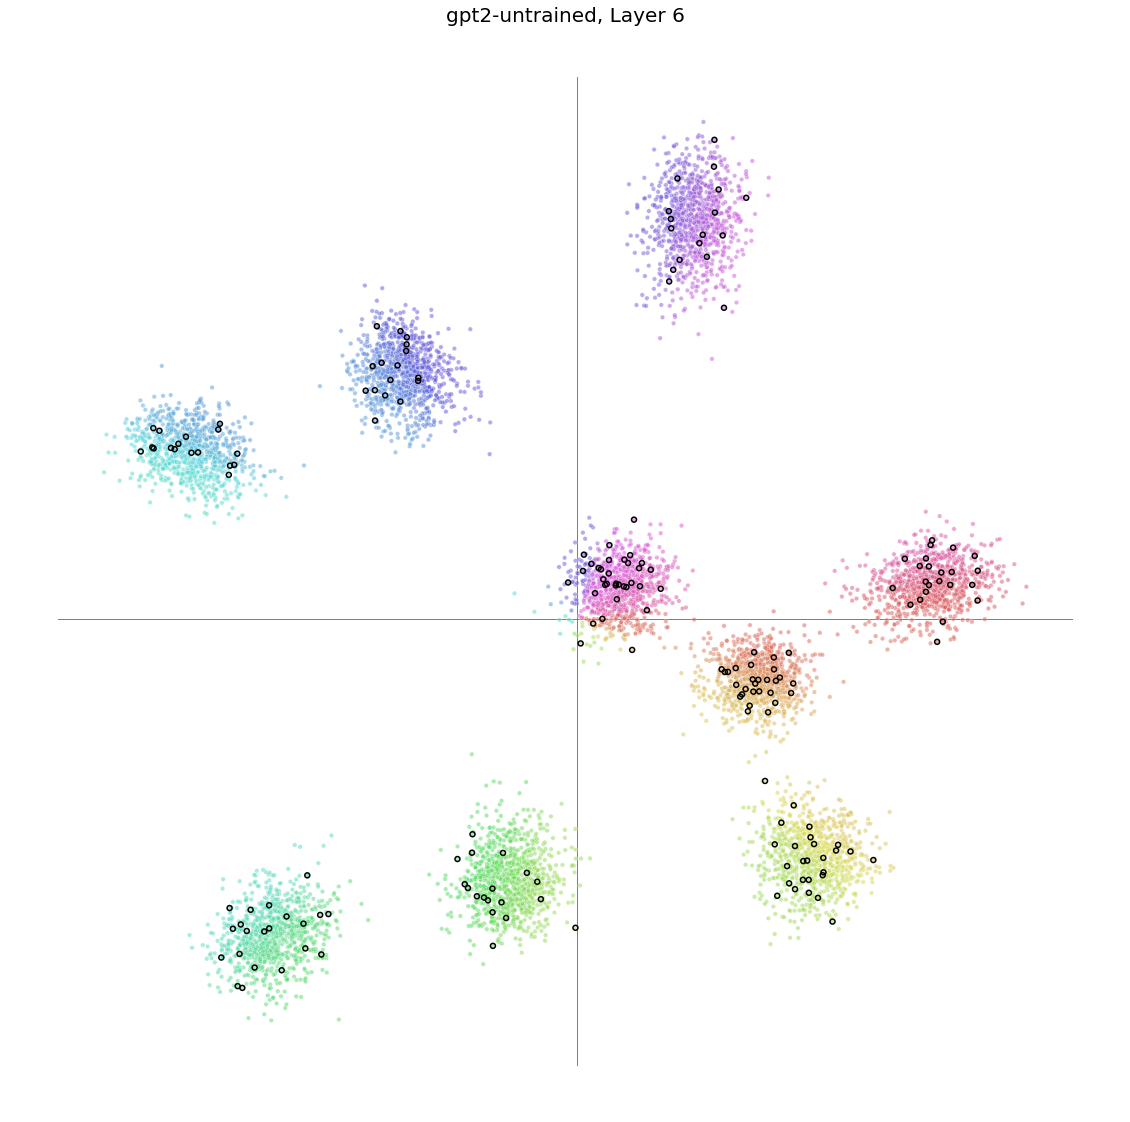

In [65]:
idx=pereira_layer_id
fig=plt.figure(figsize=(20,20))
num_colors=int(rot.shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
#plt.suptitle(f"{group}\n{name}",fontsize=16)

ax=plt.subplot(1,1,1)
l_v=loadings_p12[idx]
onehot_target=torch.nn.functional.one_hot(torch.tensor(rot_list[idx]))
val,indicies=torch.max(onehot_target.transpose(1,0),dim=1)
col_order=line_cols[indicies,:]
if plot_ev_select:
    scatter1=ax.scatter(l_v[ev_sent_id,0],l_v[ev_sent_id,1],s=25,c='none',edgecolors=(0,0,0),linewidth=1.5,alpha=1,zorder=4)
scatter_pca=ax.scatter(l_v[:,0],l_v[:,1],s=20,c=col_order,edgecolors=(1,1,1),alpha=.5,linewidth=.5,zorder=3)
right_side = ax.spines["right"]
right_side. set_visible(False)
right_side = ax.spines["top"]
right_side. set_visible(False)
right_side = ax.spines["left"]
right_side. set_visible(False)
right_side = ax.spines["bottom"]
right_side. set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlim(ax_lims[:,0])
#ax.set_ylim(ax_lims[:,1])
ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
ax.set_title(f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}",fontsize=20)
ax.spines['left'].set_position(('axes', 0.00))
ax.spines['left'].set_smart_bounds(True)
    #ax.yaxis.set_ticks_position('left')   
ax.spines['left'].set_position(('axes', 0.00))
    # ax.spines['left'].set_smart_bounds(True)
ax.yaxis.set_ticks_position('left')

ax.spines['bottom'].set_position(('axes', 0.00))


In [ ]:

num_layers=len(X_embedded_list)
num_cols=1
num_rows=int(np.ceil(num_layers/num_cols))
fig=plt.figure(figsize=(20*num_cols,20*num_rows))
num_colors=int(rot.shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
plt.suptitle(f"{group}\n{name}",fontsize=16)
for idx in tqdm(range(len(rot_list))):
    ax=plt.subplot(num_rows,num_cols,idx+1)
    points=X_embedded_list[idx]
    #points=loadings_p12[idx]
    onehot_target=torch.nn.functional.one_hot(torch.tensor(rot_list[idx]))
    val,indicies=torch.max(onehot_target.transpose(1,0),dim=1)
    col_order=line_cols[indicies,:]
    if plot_ev_select:
        scatter1=ax.scatter(l_v[ev_sent_id,0],l_v[ev_sent_id,1],s=20,c='none',edgecolors=(0,0,0),linewidth=1.5,alpha=1,zorder=4)
    scatter_pca=ax.scatter(l_v[:,0],l_v[:,1],s=15,c=col_order,edgecolors=(1,1,1),alpha=.5,linewidth=.1,zorder=4)
    right_side = ax.spines["right"]
    right_side. set_visible(False)
    right_side = ax.spines["top"]
    right_side. set_visible(False)
    right_side = ax.spines["left"]
    right_side. set_visible(False)
    right_side = ax.spines["bottom"]
    right_side. set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.set_title(f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}",fontsize=12)
    ax.spines['left'].set_position(('axes', 0.00))
    ax.spines['left'].set_smart_bounds(True)
    #ax.yaxis.set_ticks_position('left')   
    ax.spines['left'].set_position(('axes', 0.00))
    # ax.spines['left'].set_smart_bounds(True)
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('axes', 0.00))
    labels = ['{0}'.format(sentences[x]) for x in range(len(sentences))]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter_pca, labels=labels)
    #tooltip1 = mpld3.plugins.PointLabelTooltip(scatter1, labels=labels_1)
    mpld3.plugins.connect(fig,tooltip)
#plt.suptitle(f"{group}\n{name}",fontsize=16)
#mpld3.save_html(fig, f'{group}_tSNE_90.html')
#mpld3.enable_notebook()
mpld3.save_html(fig, os.path.join(ANALYZE_DIR,f"{name}_PCA_85.html"))

In [174]:
from tsnecuda import TSNE
var_explained=[]
loadings=[]
components=[]
data_recon=[]
X_embedded_list=[]
k=50

for idx, act in tqdm(enumerate(activation_list)):
    # act must be in m sample * n feature shape 
    u,s,v=torch.pca_lowrank(act,q=500)
    loadings.append(torch.matmul(u,torch.diag(s)))
    components.append(v)
    var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
    
    # construct a new representation based on 90%
    idx_90=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
    print(idx_90.sum())
    #idx_50=np.arange(30)
    #v_90=v[:,idx_90]
    #s_90=s[idx_90]
    #u_90=u[:,idx_90]
    #X_new=torch.matmul(torch.matmul(u_90,torch.diagflat(s_90)),v_90.transpose(1,0))
    cols=list(torch.where(idx_90)[0].cpu().numpy())
    act_50=torch.matmul(act,v[:,:k])
    act_90=torch.matmul(act,v[:,cols])


    # do tsne on low dim representation 
    X_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200,n_iter=8000).fit_transform(act_90.cpu())
    X_embedded_list.append(X_embedded)
var_explained=torch.stack(var_explained).cpu()

0it [00:00, ?it/s]

tensor(303, device='cuda:0')


1it [00:05,  5.92s/it]

tensor(271, device='cuda:0')


2it [00:11,  5.90s/it]

tensor(268, device='cuda:0')


3it [00:17,  5.92s/it]

tensor(266, device='cuda:0')


4it [00:23,  5.89s/it]

tensor(271, device='cuda:0')


5it [00:29,  5.88s/it]

tensor(283, device='cuda:0')


6it [00:35,  5.91s/it]

tensor(280, device='cuda:0')


7it [00:41,  5.90s/it]

tensor(276, device='cuda:0')


8it [00:47,  5.86s/it]

tensor(274, device='cuda:0')


9it [00:52,  5.84s/it]

tensor(273, device='cuda:0')


10it [00:58,  5.84s/it]

tensor(274, device='cuda:0')


11it [01:04,  5.84s/it]

tensor(273, device='cuda:0')


12it [01:10,  5.88s/it]

tensor(288, device='cuda:0')


13it [01:16,  5.88s/it]


In [175]:

import mpld3

In [ ]:
num_layers=len(X_embedded_list)
num_cols=1
num_rows=int(np.ceil(num_layers/num_cols))
fig=plt.figure(figsize=(20*num_cols,20*num_rows))
num_colors=int(rot.shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
plt.suptitle(f"{group}\n{name}",fontsize=16)
for idx in tqdm(range(len(rot_list))):
    ax=plt.subplot(num_rows,num_cols,idx+1)
    points=X_embedded_list[idx]
    #points=loadings_p12[idx]
    onehot_target=torch.nn.functional.one_hot(torch.tensor(rot_list[idx]))
    val,indicies=torch.max(onehot_target.transpose(1,0),dim=1)
    col_order=line_cols[indicies,:]
    if plot_ev_select:
        scatter1=ax.scatter(points[ev_sent_id,0],points[ev_sent_id,1],s=45,c='none',edgecolors=(.2,.2,.2),linewidth=2,alpha=.8,zorder=2)
    scatter_tsne=ax.scatter(points[:,0],points[:,1],s=25,c=col_order,edgecolors=(1,1,1),alpha=.7,linewidth=.1,zorder=4)
    right_side = ax.spines["right"]
    right_side. set_visible(False)
    right_side = ax.spines["top"]
    right_side. set_visible(False)
    right_side = ax.spines["left"]
    right_side. set_visible(False)
    right_side = ax.spines["bottom"]
    right_side. set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.set_title(f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}",fontsize=12)
    ax.spines['left'].set_position(('axes', 0.00))
    ax.spines['left'].set_smart_bounds(True)
    #ax.yaxis.set_ticks_position('left')   
    ax.spines['left'].set_position(('axes', 0.00))
    # ax.spines['left'].set_smart_bounds(True)
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('axes', 0.00))
    labels = ['{0}'.format(sentences[x]) for x in range(len(sentences))]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter_tsne, labels=labels)
    #tooltip1 = mpld3.plugins.PointLabelTooltip(scatter1, labels=labels_1)
    mpld3.plugins.connect(fig,tooltip)
#plt.suptitle(f"{group}\n{name}",fontsize=16)
#mpld3.save_html(fig, f'{group}_tSNE_90.html')
#mpld3.enable_notebook()
mpld3.save_html(fig, os.path.join(ANALYZE_DIR,f"{name}_tSNE_85.html"))

0


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


1
2
3
4
5
6
7
8
9
10
11
12


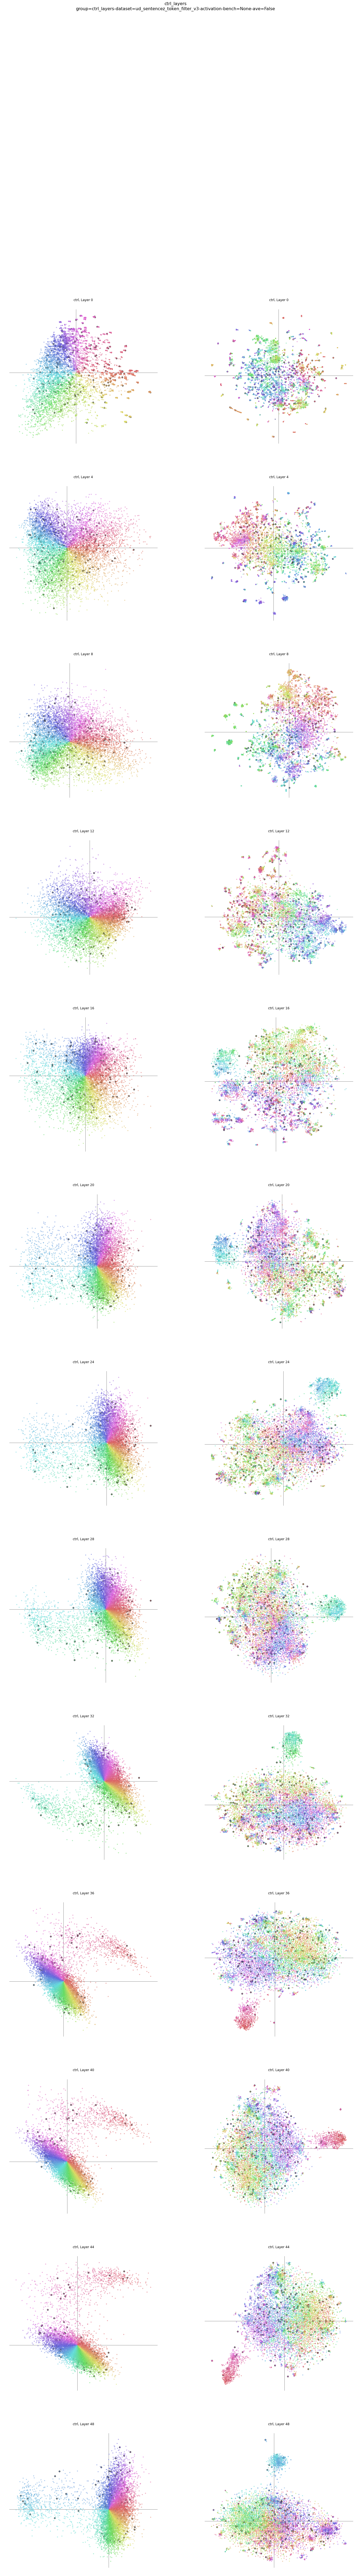

In [177]:
# plot both pca and tsne 
num_layers=len(X_embedded_list)
num_cols=2
num_rows=int(np.ceil(num_layers))
fig=plt.figure(figsize=(12*num_cols,12*num_rows))
num_colors=int(rot.shape[0])
h0=sns.color_palette("hls", num_colors,as_cmap=True)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
plt.suptitle(f"{group}\n{name}",fontsize=16)
for idx in range(len(rot_list)):
    print(idx)
    l_v=loadings_p12[idx]
    points=X_embedded_list[idx]
    #points=loadings_p12[idx]
    onehot_target=torch.nn.functional.one_hot(torch.tensor(rot_list[idx]))
    val,indicies=torch.max(onehot_target.transpose(1,0),dim=1)
    col_order=line_cols[indicies,:]
    # plot pca 
    ax=plt.subplot(num_rows,num_cols,num_cols*idx+1)
    if plot_ev_select:
        scatter1=ax.scatter(l_v[ev_sent_id,0],l_v[ev_sent_id,1],s=20,c='none',edgecolors=(0,0,0),linewidth=1.5,alpha=1,zorder=4)
    scatter_pca=ax.scatter(l_v[:,0],l_v[:,1],s=15,c=col_order,edgecolors=(1,1,1),alpha=.5,linewidth=.1,zorder=4)
    right_side = ax.spines["right"]
    right_side. set_visible(False)
    right_side = ax.spines["top"]
    right_side. set_visible(False)
    right_side = ax.spines["left"]
    right_side. set_visible(False)
    right_side = ax.spines["bottom"]
    right_side. set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.set_title(f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}",fontsize=12)
    ax.spines['left'].set_position(('axes', 0.00))
    ax.spines['left'].set_smart_bounds(True)
    #ax.yaxis.set_ticks_position('left')   
    ax.spines['left'].set_position(('axes', 0.00))
    # ax.spines['left'].set_smart_bounds(True)
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('axes', 0.00))

    labels = ['{0}'.format(sentences[x]) for x in range(len(sentences))]
    tooltip_pca = mpld3.plugins.PointLabelTooltip(scatter_pca, labels=labels)
    #tooltip1 = mpld3.plugins.PointLabelTooltip(scatter1, labels=labels_1)
    mpld3.plugins.connect(fig,tooltip_pca)


    
    ax=plt.subplot(num_rows,num_cols,num_cols*idx+2)
    if plot_ev_select:
        scatter1=ax.scatter(points[ev_sent_id,0],points[ev_sent_id,1],s=20,c='none',edgecolors=(0,0,0),linewidth=1.5,alpha=1,zorder=4)
    scatter_tsne=ax.scatter(points[:,0],points[:,1],s=15,c=col_order,edgecolors=(1,1,1),alpha=.5,linewidth=.1,zorder=4)
    right_side = ax.spines["right"]
    right_side. set_visible(False)
    right_side = ax.spines["top"]
    right_side. set_visible(False)
    right_side = ax.spines["left"]
    right_side. set_visible(False)
    right_side = ax.spines["bottom"]
    right_side. set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
    ax.set_title(f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}",fontsize=12)
    ax.spines['left'].set_position(('axes', 0.00))
    ax.spines['left'].set_smart_bounds(True)
    #ax.yaxis.set_ticks_position('left')   
    ax.spines['left'].set_position(('axes', 0.00))
    # ax.spines['left'].set_smart_bounds(True)
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('axes', 0.00))

    labels = ['{0}'.format(sentences[x]) for x in range(len(sentences))]
    tooltip_tsne = mpld3.plugins.PointLabelTooltip(scatter_tsne, labels=labels)
    #tooltip1 = mpld3.plugins.PointLabelTooltip(scatter1, labels=labels_1)
    mpld3.plugins.connect(fig,tooltip_tsne)
#plt.suptitle(f"{group}\n{name}",fontsize=16)
mpld3.save_html(fig, os.path.join(ANALYZE_DIR,f"{name}_PCA_tSNE_85.html"))
#mpld3.enable_notebook()

